In [ ]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from fitle import Param, INPUT, fit, Cost, gaussian, convolve, index
import vector
import mplhep
import scipy
import iminuit
mplhep.style.use(mplhep.style.LHCb2)

## Setup

Import the required libraries for binning scheme analysis.

loading in MERR, nominal error distribution

In [2]:
f = uproot.open("../data/MERR.root")

In [3]:
Dp_DTF_MERR = f['DecayTree']["Dp_DTF_MERR"].array()

loading in monte carlo simulations

In [4]:
Dp_tree=uproot.open("../data/mc/raw/Dp.root")["Truth"]["t"]

Dp_ssK_TRUEP_E = np.asarray(Dp_tree["ssK_TRUEP_E"])
Dp_ssK_TRUEP_X = np.asarray(Dp_tree["ssK_TRUEP_X"])
Dp_ssK_TRUEP_Y = np.asarray(Dp_tree["ssK_TRUEP_Y"])
Dp_ssK_TRUEP_Z = np.asarray(Dp_tree["ssK_TRUEP_Z"])

Dp_osK_TRUEP_E = np.asarray(Dp_tree["osK_TRUEP_E"])
Dp_osK_TRUEP_X = np.asarray(Dp_tree["osK_TRUEP_X"])
Dp_osK_TRUEP_Y = np.asarray(Dp_tree["osK_TRUEP_Y"])
Dp_osK_TRUEP_Z = np.asarray(Dp_tree["osK_TRUEP_Z"])

Dp_sspi_TRUEP_E = np.asarray(Dp_tree["sspi_TRUEP_E"])
Dp_sspi_TRUEP_X = np.asarray(Dp_tree["sspi_TRUEP_X"])
Dp_sspi_TRUEP_Y = np.asarray(Dp_tree["sspi_TRUEP_Y"])
Dp_sspi_TRUEP_Z = np.asarray(Dp_tree["sspi_TRUEP_Z"])

Dp_ssK_vec   = vector.array({"px": Dp_ssK_TRUEP_X, "py":Dp_ssK_TRUEP_Y, "pz":Dp_ssK_TRUEP_Z, "E":Dp_ssK_TRUEP_E})
Dp_osK_vec   = vector.array({"px": Dp_osK_TRUEP_X, "py":Dp_osK_TRUEP_Y, "pz":Dp_osK_TRUEP_Z, "E":Dp_osK_TRUEP_E})
Dp_sspi_vec  = vector.array({"px": Dp_sspi_TRUEP_X, "py":Dp_sspi_TRUEP_Y, "pz":Dp_sspi_TRUEP_Z, "E":Dp_sspi_TRUEP_E})

Dp_mother_vec = Dp_ssK_vec + Dp_osK_vec + Dp_sspi_vec
Dp_mother_mass = Dp_mother_vec.mass

In [5]:
Ds_tree=uproot.open("../data/mc/raw/Ds.root")["Truth"]["t"]

Ds_ssK_TRUEP_E = np.asarray(Ds_tree["ssK_TRUEP_E"])
Ds_ssK_TRUEP_X = np.asarray(Ds_tree["ssK_TRUEP_X"])
Ds_ssK_TRUEP_Y = np.asarray(Ds_tree["ssK_TRUEP_Y"])
Ds_ssK_TRUEP_Z = np.asarray(Ds_tree["ssK_TRUEP_Z"])

Ds_osK_TRUEP_E = np.asarray(Ds_tree["osK_TRUEP_E"])
Ds_osK_TRUEP_X = np.asarray(Ds_tree["osK_TRUEP_X"])
Ds_osK_TRUEP_Y = np.asarray(Ds_tree["osK_TRUEP_Y"])
Ds_osK_TRUEP_Z = np.asarray(Ds_tree["osK_TRUEP_Z"])

Ds_sspi_TRUEP_E = np.asarray(Ds_tree["sspi_TRUEP_E"])
Ds_sspi_TRUEP_X = np.asarray(Ds_tree["sspi_TRUEP_X"])
Ds_sspi_TRUEP_Y = np.asarray(Ds_tree["sspi_TRUEP_Y"])
Ds_sspi_TRUEP_Z = np.asarray(Ds_tree["sspi_TRUEP_Z"])

Ds_ssK_vec   = vector.array({"px": Ds_ssK_TRUEP_X, "py":Ds_ssK_TRUEP_Y, "pz":Ds_ssK_TRUEP_Z, "E":Ds_ssK_TRUEP_E})
Ds_osK_vec   = vector.array({"px": Ds_osK_TRUEP_X, "py":Ds_osK_TRUEP_Y, "pz":Ds_osK_TRUEP_Z, "E":Ds_osK_TRUEP_E})
Ds_sspi_vec  = vector.array({"px": Ds_sspi_TRUEP_X, "py":Ds_sspi_TRUEP_Y, "pz":Ds_sspi_TRUEP_Z, "E":Ds_sspi_TRUEP_E})

Ds_mother_vec = Ds_ssK_vec + Ds_osK_vec + Ds_sspi_vec
Ds_mother_mass = Ds_mother_vec.mass

PHOTOS Distribution

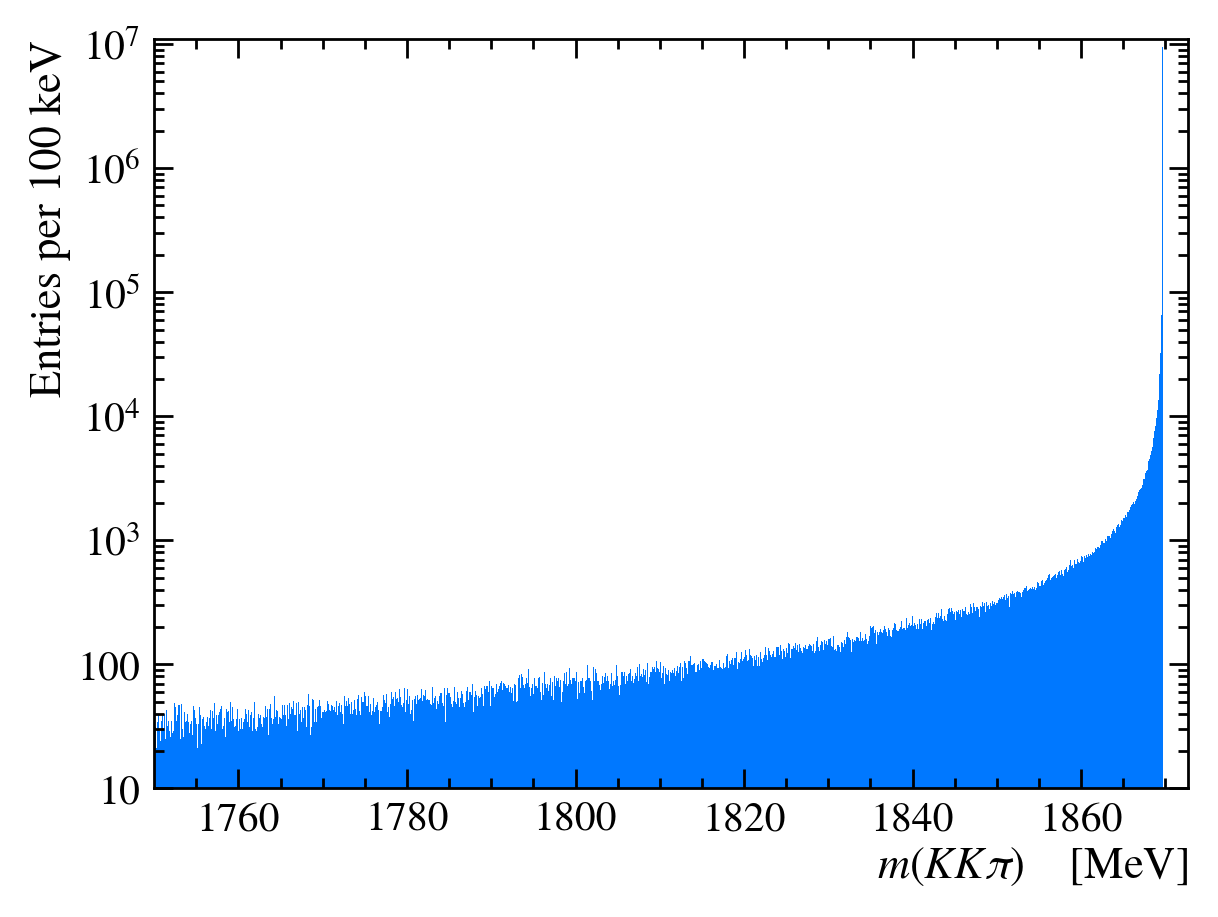

In [7]:
nC1, bins, blas = plt.hist(Dp_mother_mass, range=(1750, np.max(Dp_mother_mass)),bins=1200)
plt.ylabel(f'Entries per 100 keV')
plt.xlabel('$m(K K \pi)$    [MeV]')
plt.yscale('log')
plt.axis([1750,np.max(Dp_mother_mass)+3,10,1.15*np.max(nC1)])
plt.show()

In [21]:
1/1200*100

0.08333333333333334

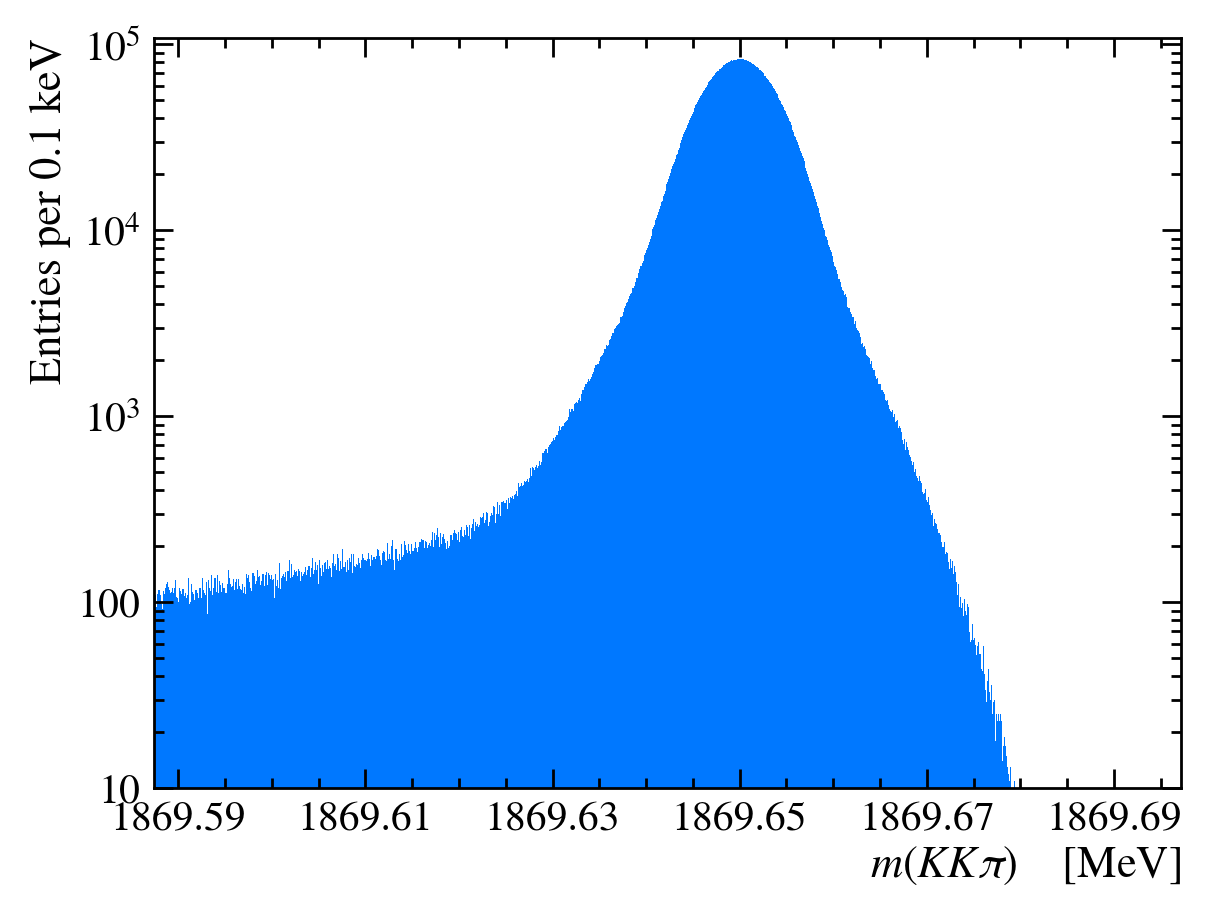

In [8]:
nC2,a,b = plt.hist(Dp_mother_mass, range=(bins[-2], np.max(Dp_mother_mass)),bins=1000)
plt.ylabel(f'Entries per 0.1 keV')
plt.xlabel('$m(K K \pi)$    [MeV]')
plt.yscale('log')
plt.axis([bins[-2],np.max(Dp_mother_mass)+.01,10,1.3*np.max(nC2)])
plt.xticks([1869.59,1869.61,1869.63,1869.65,1869.67,1869.69])
try:
    plt.ticklabel_format(useOffset=False)
except:
    print()
plt.show()

In [9]:
len(Dp_mother_mass[Dp_mother_mass> np.max(Dp_mother_mass)-0.1]) / len(Dp_mother_mass)

0.9481731

Define hyperbolic tan binning

In [7]:
def tanh_bin(bin_c,bin_min,bin_max, beta,alpha):
    b = (bin_max-bin_min-alpha*bin_c)/np.tanh(bin_c/beta)
    return bin_min + b*np.tanh(np.arange(0,bin_c+1)/beta) + alpha * np.arange(0,bin_c+1)

Hyperbolic Tan binning variation

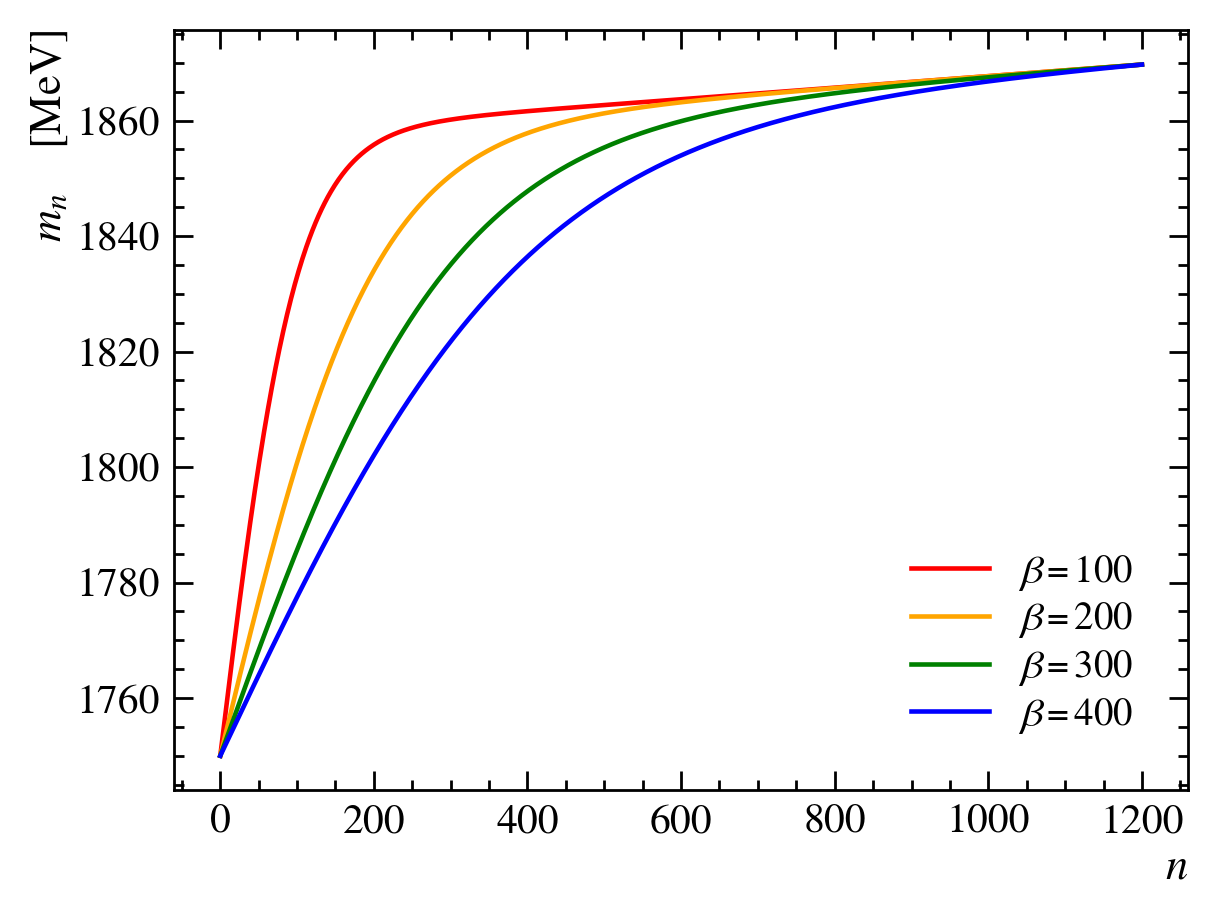

In [9]:
plt.plot(tanh_bin(1200, 1750, np.max(Dp_mother_mass), 100,0.01), color='red',label=r"$\beta=100$")
plt.plot(tanh_bin(1200, 1750, np.max(Dp_mother_mass), 200,0.01), color='orange',label=r"$\beta=200$")
plt.plot(tanh_bin(1200, 1750, np.max(Dp_mother_mass), 300,0.01), color='green',label=r"$\beta=300$")
plt.plot(tanh_bin(1200, 1750, np.max(Dp_mother_mass), 400,0.01),color='blue', label=r"$\beta=400$")
plt.xlabel(r"$n$")
plt.ylabel(r"$m_n$    [MeV]")
plt.legend()

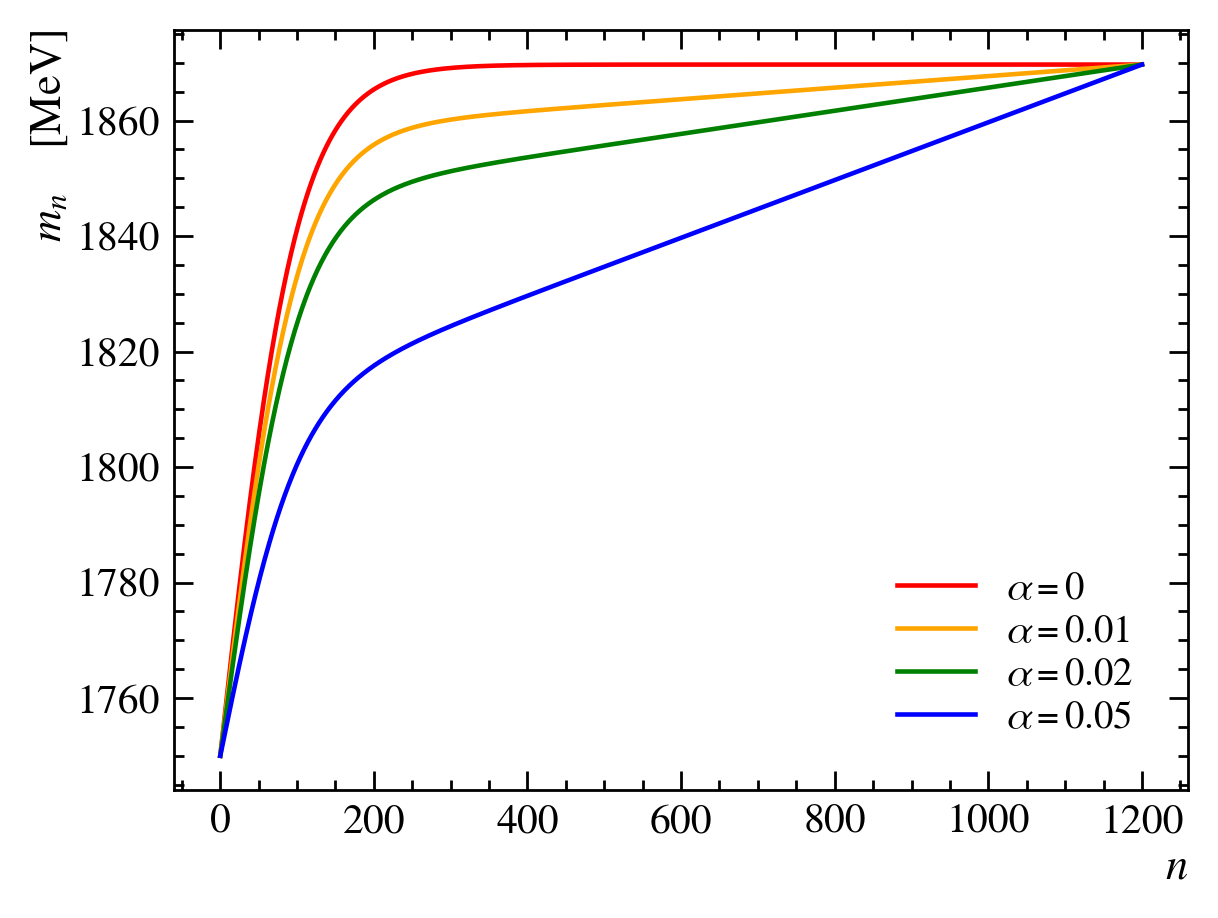

In [10]:
plt.plot(tanh_bin(1200, 1750, np.max(Dp_mother_mass), 100,0), color='red',label=r"$\alpha=0$")
plt.plot(tanh_bin(1200, 1750, np.max(Dp_mother_mass), 100,0.01), color='orange',label=r"$\alpha=0.01$")
plt.plot(tanh_bin(1200, 1750, np.max(Dp_mother_mass), 100,0.02), color='green',label=r"$\alpha=0.02$")
plt.plot(tanh_bin(1200, 1750, np.max(Dp_mother_mass), 100,0.05), color='blue',label=r"$\alpha=0.05$")
plt.xlabel(r"$n$")
plt.ylabel(r"$m_n$    [MeV]")
plt.legend()

Binning of the PHOTOS distribution

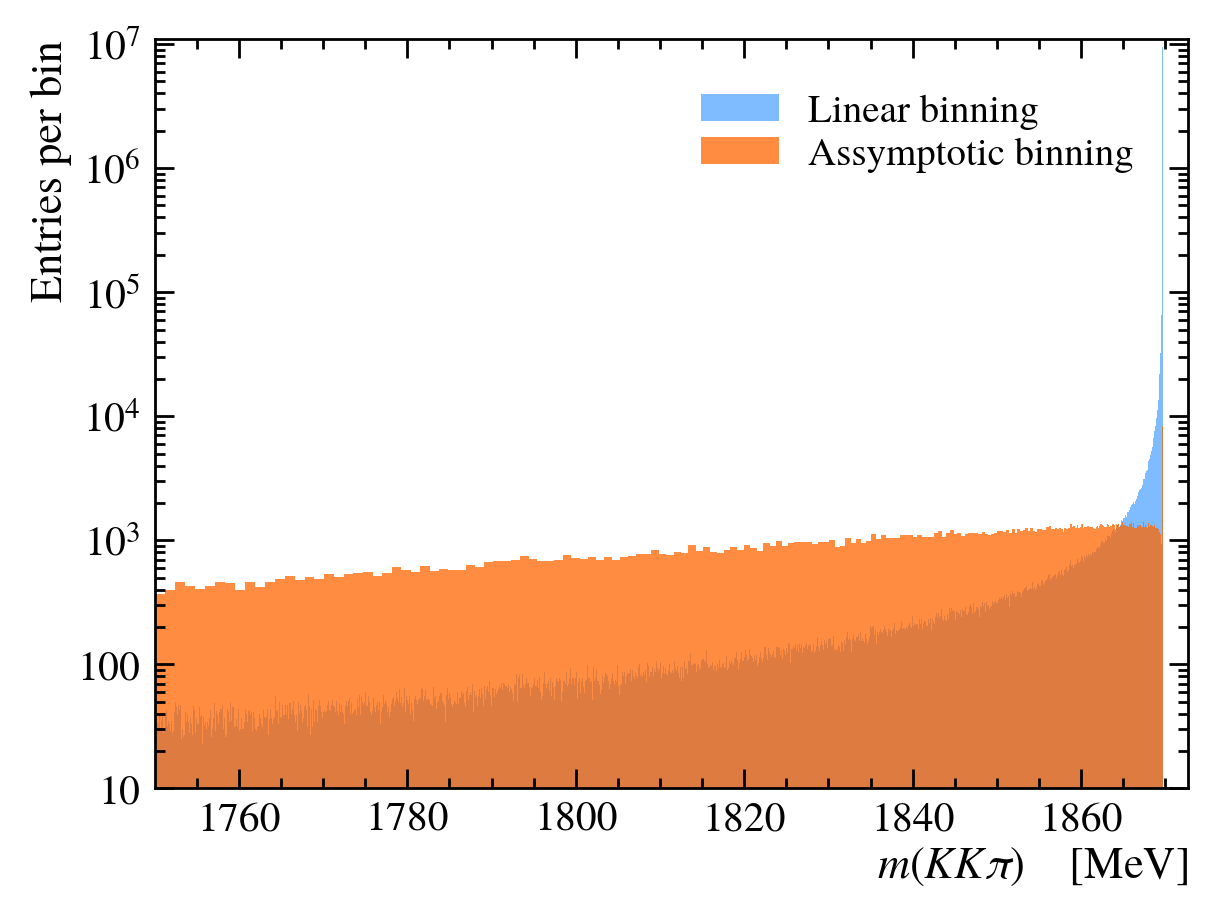

In [11]:
nC, bins, blas = plt.hist(Dp_mother_mass, label="Linear binning", range=(1750, np.max(Dp_mother_mass)),bins=1200, alpha=0.5)
plt.hist(Dp_mother_mass, label="Assymptotic binning", bins=tanh_bin(1200, 1750, np.max(Dp_mother_mass), 100,0.0001), alpha=0.75)
plt.ylabel('Entries per bin')
plt.xlabel('$m(K K \pi)$    [MeV]')
plt.yscale('log')
plt.axis([1750,np.max(Dp_mother_mass)+3,10,1.15*np.max(nC)])
plt.legend()
plt.show()

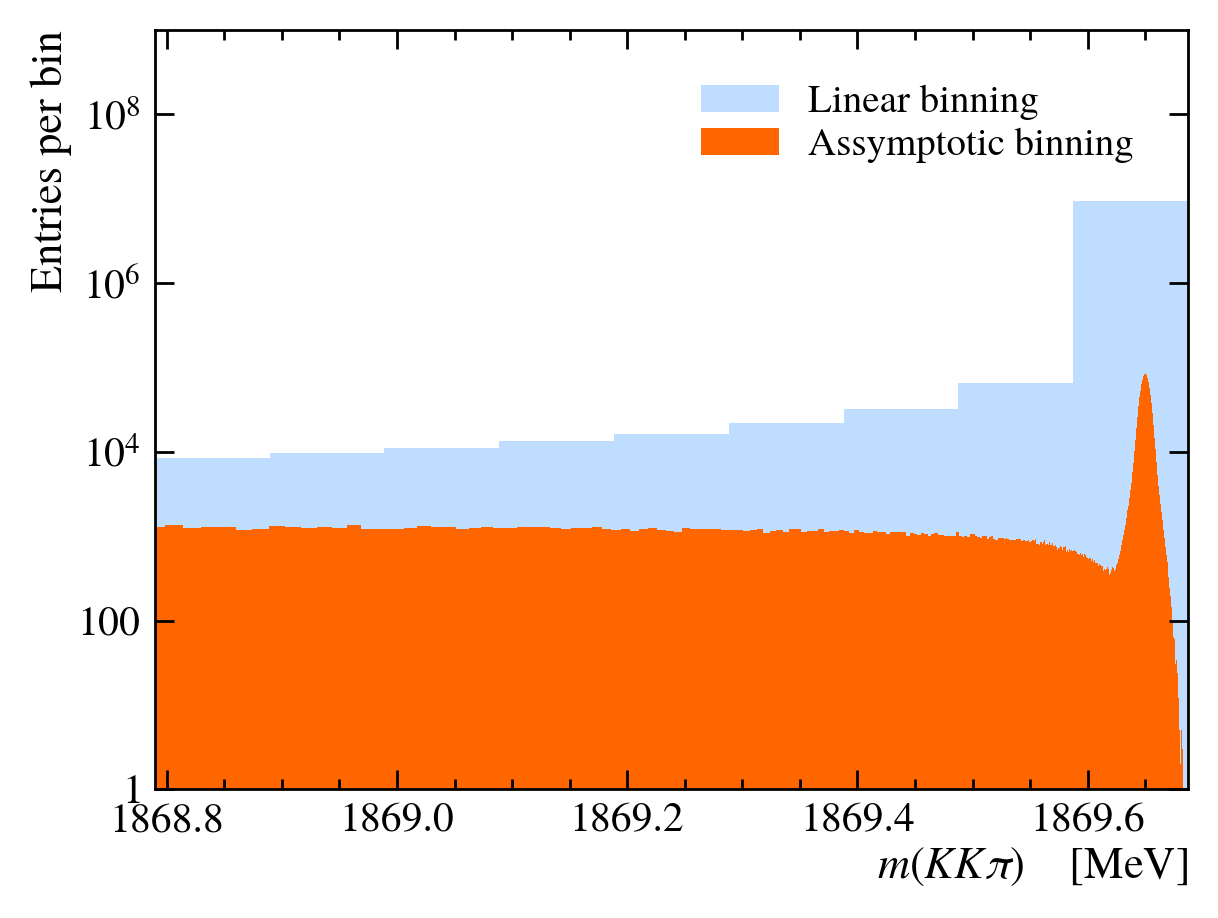

In [12]:
plt.hist(Dp_mother_mass, label="Linear binning", range=(1750, np.max(Dp_mother_mass)), bins=1200,alpha=0.25)
plt.hist(Dp_mother_mass, label="Assymptotic binning", bins=tanh_bin(1200, 1750, np.max(Dp_mother_mass), 100,0.0001))
plt.ylabel('Entries per bin')
plt.xlabel('$m(K K \pi)$    [MeV]')
plt.legend()
plt.axis([bins[-10],np.max(Dp_mother_mass), 1,10**9])
plt.yscale('log')

save the data

In [38]:
counts, edges = np.histogram(Dp_mother_mass, bins=tanh_bin(1200, 1750, np.max(Dp_mother_mass), 100,0.0001))
centers = (edges[1:] + edges[:-1]) / 2
np.save('../data/mc/histograms/Dp.npy', np.array([centers,counts]))

In [13]:
counts, edges = np.histogram(Ds_mother_mass, bins=tanh_bin(1200, 1750, np.max(Ds_mother_mass), 100,0.0001))
centers = (edges[1:] + edges[:-1]) / 2
np.save('../data/mc/histograms/Ds.npy', np.array([centers,counts]))

now for kpp + comparisons

In [7]:
kpipi_tree=uproot.open("../data/mc/raw/kpp.root")["Truth"]["t"]

In [8]:
kpipi_K_TRUEP_E = np.asarray(kpipi_tree["K_TRUEP_E"])
kpipi_K_TRUEP_X = np.asarray(kpipi_tree["K_TRUEP_X"])
kpipi_K_TRUEP_Y = np.asarray(kpipi_tree["K_TRUEP_Y"])
kpipi_K_TRUEP_Z = np.asarray(kpipi_tree["K_TRUEP_Z"])

kpipi_pi1_TRUEP_E = np.asarray(kpipi_tree["pi1_TRUEP_E"])
kpipi_pi1_TRUEP_X = np.asarray(kpipi_tree["pi1_TRUEP_X"])
kpipi_pi1_TRUEP_Y = np.asarray(kpipi_tree["pi1_TRUEP_Y"])
kpipi_pi1_TRUEP_Z = np.asarray(kpipi_tree["pi1_TRUEP_Z"])

kpipi_pi2_TRUEP_E = np.asarray(kpipi_tree["pi2_TRUEP_E"])
kpipi_pi2_TRUEP_X = np.asarray(kpipi_tree["pi2_TRUEP_X"])
kpipi_pi2_TRUEP_Y = np.asarray(kpipi_tree["pi2_TRUEP_Y"])
kpipi_pi2_TRUEP_Z = np.asarray(kpipi_tree["pi2_TRUEP_Z"])
kpipi_TRUEP_E = np.asarray(kpipi_tree["Dp_TRUEP_E"])
kpipi_TRUEP_X = np.asarray(kpipi_tree["Dp_TRUEP_X"])
kpipi_TRUEP_Y = np.asarray(kpipi_tree["Dp_TRUEP_Y"])
kpipi_TRUEP_Z = np.asarray(kpipi_tree["Dp_TRUEP_Z"])

kpipi_K_vec   = vector.array({"px": kpipi_K_TRUEP_X, "py":kpipi_K_TRUEP_Y, "pz":kpipi_K_TRUEP_Z, "E":kpipi_K_TRUEP_E})
kpipi_pi1_vec   = vector.array({"px": kpipi_pi1_TRUEP_X, "py":kpipi_pi1_TRUEP_Y, "pz":kpipi_pi1_TRUEP_Z, "E":kpipi_pi1_TRUEP_E})
kpipi_pi2_vec  = vector.array({"px": kpipi_pi2_TRUEP_X, "py":kpipi_pi2_TRUEP_Y, "pz":kpipi_pi2_TRUEP_Z, "E":kpipi_pi2_TRUEP_E})
kpipi_true_vec  = vector.array({"px": kpipi_TRUEP_X, "py":kpipi_TRUEP_Y, "pz":kpipi_TRUEP_Z, "E":kpipi_TRUEP_E})
kpipi_mother_vec = kpipi_K_vec + kpipi_pi1_vec + kpipi_pi2_vec
kpipi_mother_mass = kpipi_mother_vec.mass
kpipi_true_mass = kpipi_true_vec.mass

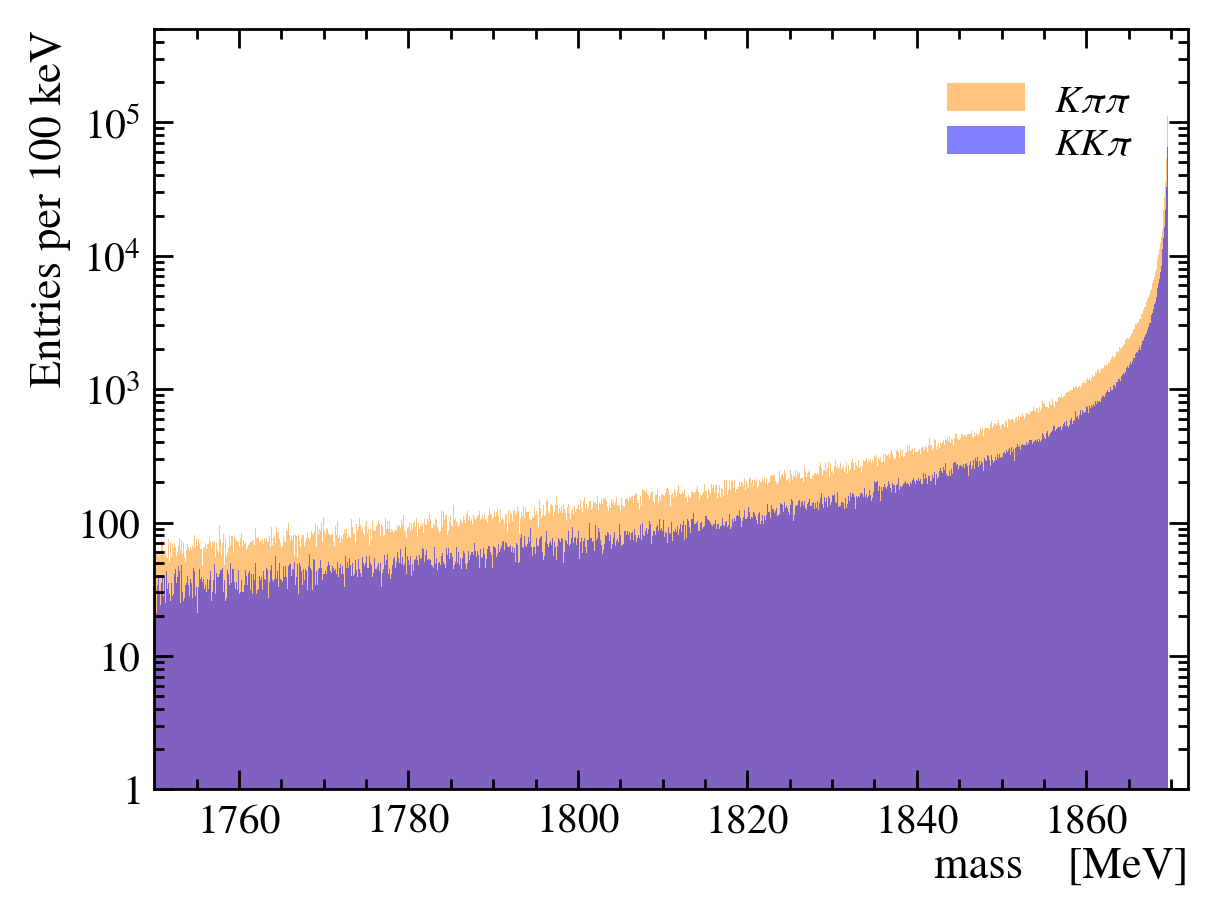

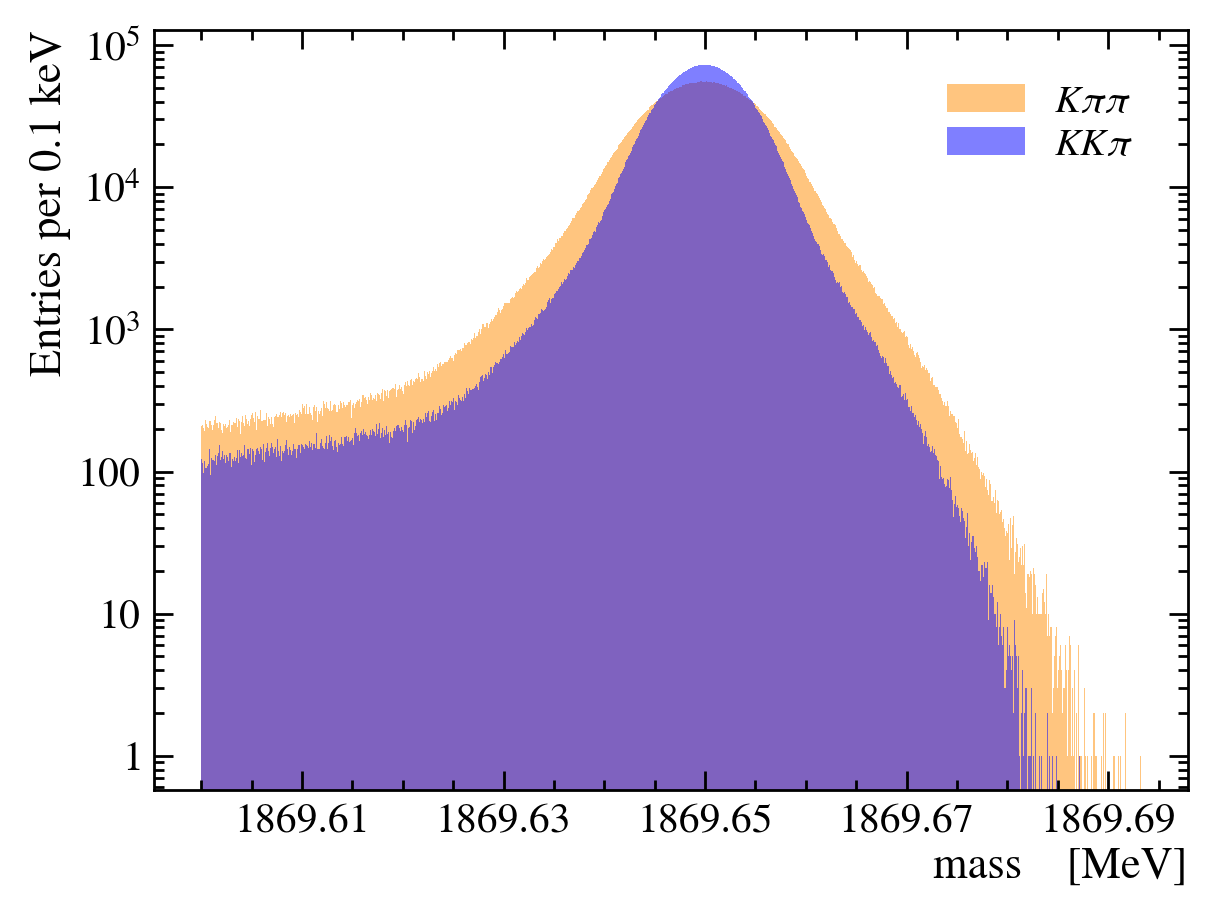

In [9]:
import matplotlib
x=np.linspace(-5,5,1000)
fig, ax1 = plt.subplots()


ax1.hist(kpipi_mother_mass, bins=1200, range=(1750,np.max(kpipi_mother_mass)),color='darkorange',alpha=0.5, label='$K\pi\pi$')
ax1.hist(Dp_mother_mass, bins=1200, range=(1750,np.max(Dp_mother_mass)),color='blue',alpha=0.5, label='$KK\pi$')
ax1.axis([1750,1872,1,5*10**5])
ax1.set(xlabel='mass    [MeV]',ylabel='Entries per 100 keV', yscale='log')
ax1.legend()
fig.show()

fig, ax2 = plt.subplots()

ax2.hist(kpipi_mother_mass, bins=1000, range=(1869.6,np.max(kpipi_mother_mass)),color='darkorange',alpha=0.5, label='$K\pi\pi$')
ax2.hist(Dp_mother_mass, bins=1000, range=(1869.6,np.max(Dp_mother_mass)),color='blue',alpha=0.5, label='$KK\pi$')
ax2.set(xlabel='mass    [MeV]', ylabel='Entries per 0.1 keV', yscale='log', xticks=[1869.61,1869.63,1869.65,1869.67,1869.69])
ax2.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x))))
ax2.legend()
fig.show()

In [40]:
counts, edges = np.histogram(kpipi_mother_mass, bins=tanh_bin(1200, 1750, np.max(Dp_mother_mass), 100,0.0001))
centers = (edges[1:] + edges[:-1]) / 2
np.save('../data/mc/histograms/kpp.npy', np.array([centers,counts]))

## Convolution

In [15]:
Dp_dx, Dp_c = np.load("../data/mc/histograms/Dp.npy")

## Convolution Example

Demonstrate the convolution of the MC template with a Gaussian resolution. This shows how the radiative tail affects the observed peak shape.

In [ ]:
i = index(len(Dp_c))
sigma = 6.4
model = convolve(Dp_dx, Dp_c, 1869.65, 1869.65, sigma)

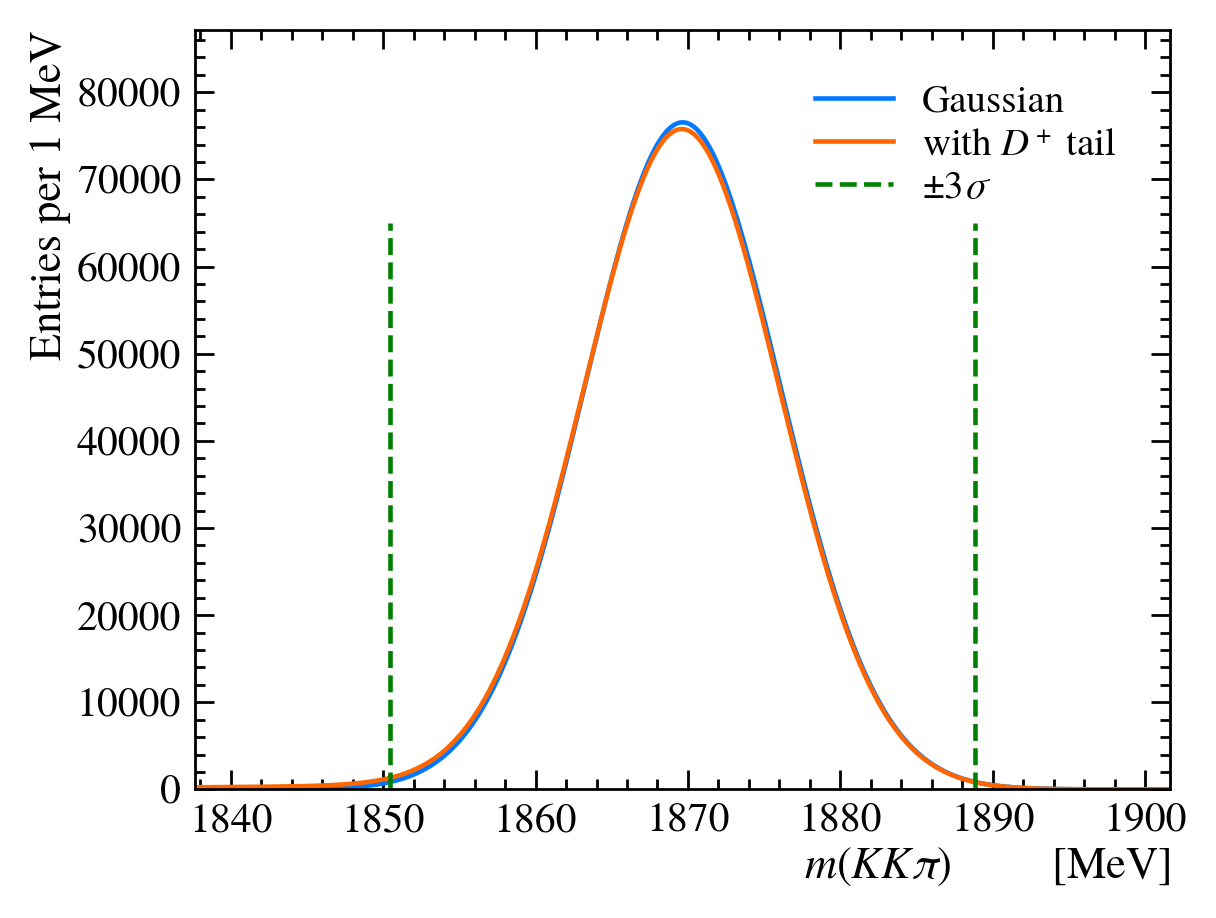

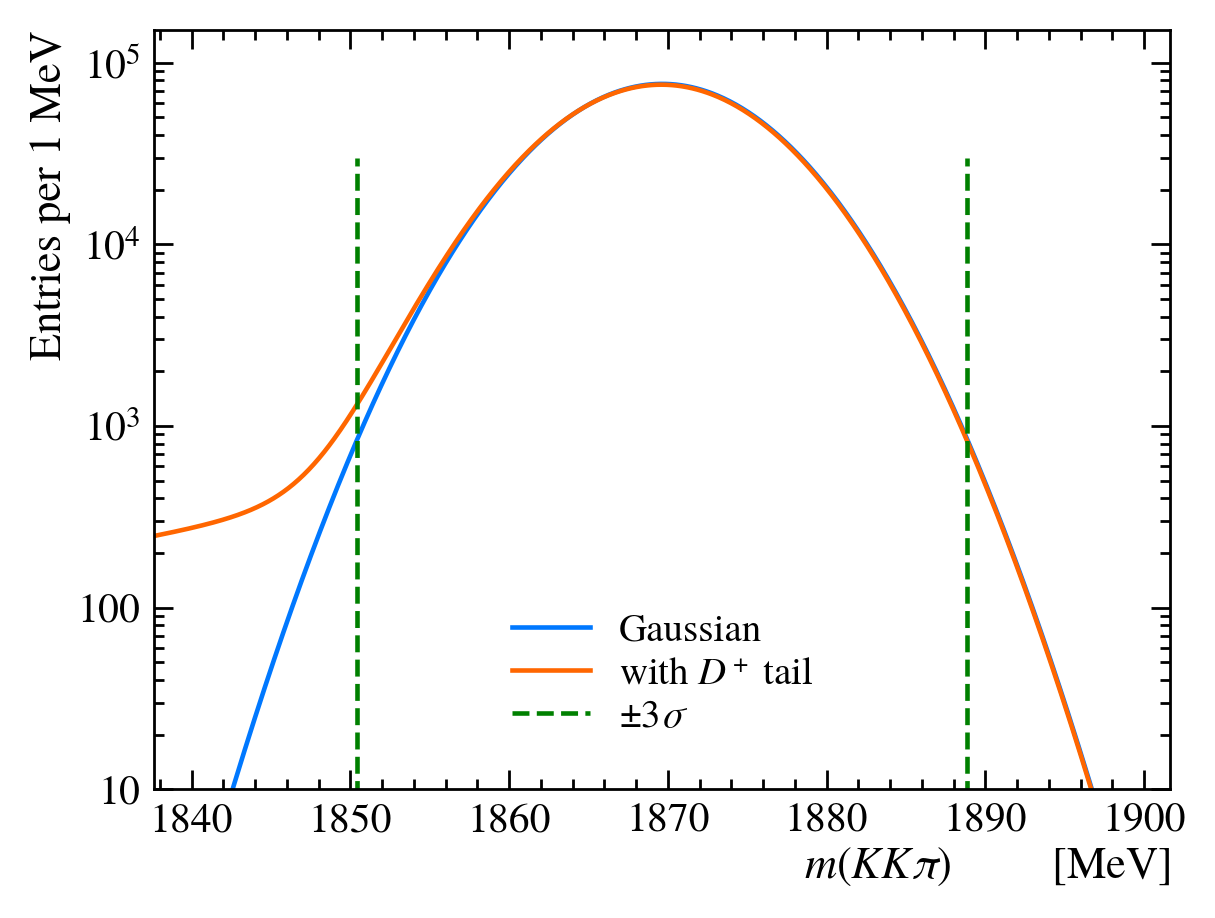

In [21]:
x=np.linspace(1869.65-5*sigma,1869.65+5*sigma,1000)
plt.plot(x,1.228e+06* scipy.stats.norm.pdf(x,1869.65,sigma), label="Gaussian")
plt.plot(x,1.228e+06* model(x), label="with $D^+$ tail")
plt.axis([1869.65-5*sigma,1869.65+5*sigma, 0, 1.228e+06*np.max(model(x))*1.15])
plt.vlines([1869.65-3*sigma, 1869.65+3*sigma],0,65000, color='green', label='$\pm3\sigma$', linestyle='dashed')
plt.ylabel('Entries per 1 MeV')
plt.xlabel('$m(K K \pi)$         [MeV]')
plt.legend()
plt.show()

plt.plot(x,1.228e+06*scipy.stats.norm.pdf(x,1869.65,sigma), label="Gaussian")
plt.plot(x,1.228e+06*model(x), label="with $D^+$ tail")
plt.ylabel('Entries per 1 MeV')
plt.xlabel('$m(K K \pi)$         [MeV]')
plt.vlines([1869.65-3*sigma, 1869.65+3*sigma],0,30000, color='green', label='$\pm3\sigma$', linestyle='dashed')
plt.axis([1869.65-5*sigma,1869.65+5*sigma,10, 2*1.228e+06*np.max(model(x))])
plt.yscale('log')
plt.legend()
plt.show()

### Gaussian vs Convolution Comparison

Compare a pure Gaussian with the convolved distribution. The radiative tail causes an asymmetry that extends below the peak, which is not captured by a simple Gaussian model.